# Strain plots using one dataframe
In the other Notebook, I use several different dataframes to hold analyzed data, and it's pretty messy. In this Notebook, I want to clean things up and use only a few dataframes:
- Metadata from all trials
- Mitochondrial position information from all trials
    - experiment id
    - x, y, z coordinates
    - displacement in x, y, and z directions
    - particle id
    - frame number
    - acutation pressure
    - worm strain name
    - genotype
- Pairwise measurements from mitochondria
    - experiment id
    - pair id
    - particle ids
    - frame number
    - actuation pressure
    - worm strain name
    - current distance between pairs
    - rest distance between pairs
    - stretch
    - strain

## Setup
### Choose worm strain and neuron

In [1]:
worm_strains = ['NM3573', 'GN885']
neurons = ['ALM']

allele_dict = {'NM3573': 'wild-type',
               'GN885': 'him-4(e1267)',
               'GN886': 'mec-1(e1066)',
               'GN887': 'mec-1(e1738)'}

### Experimental parameters

In [2]:
pixel_to_micron = 0.275
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/'
fig_save_dir = analyzed_data_dir + 'PreliminaryPlots/'

### Import packages

In [3]:
import yaml
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import pathlib
import line_profiler

start = time.time()
for current_worm_strain in worm_strains:
    for current_neuron in neurons:
        current_strain_TRN = current_worm_strain + '_' + current_neuron
        fig_path = pathlib.Path(fig_save_dir + current_strain_TRN)
        if fig_path.exists() is False:
            fig_path.mkdir()

## Load all the metadata

In [4]:
analyzed_trials = glob.iglob(analyzed_data_dir + '*')
all_metadata = []
for trial in analyzed_trials:
    try:
        with open(trial + '/metadata.yaml') as metadata_file:
            all_metadata.append(yaml.safe_load(metadata_file))
    except FileNotFoundError:
        pass
    except NotADirectoryError:
        pass

metadata_df = pd.DataFrame(all_metadata)

#### Select only the trials that have been successfully processed
Also get a count of the number of trials for each genotype

In [5]:
trials_for_analysis = metadata_df.loc[(metadata_df['analysis_status'] == 'Strain calculated') &
                                                   (metadata_df['actuator_center'].notnull()) &
                                                   (metadata_df['neuron'].isin(neurons))]
n_trials_dict = trials_for_analysis['worm_strain'].value_counts().to_dict()

## Load mitochondria position data into one Dataframe

In [6]:
list_of_linked_mito_dfs = []
linked_mitos_df = pd.DataFrame()
for index, row in trials_for_analysis.iterrows():
    experiment_id = row['Experiment_id']
    linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
    with open(linked_mitos_file, 'r') as yamlfile:
        linked_mitos_dict = yaml.safe_load(yamlfile)

    parsed_dict = {k: linked_mitos_dict[k] for k in (
        'frame', 'particle', 'pressure', 'x', 'y', 'z')}
    parsed_df = pd.DataFrame(parsed_dict)
    parsed_df['Experiment_id'] = experiment_id
    parsed_df['worm_strain'] = row['worm_strain']
    parsed_df['genotype'] = allele_dict[row['worm_strain']]
    list_of_linked_mito_dfs.append(parsed_df)

linked_mitos_df = pd.concat(list_of_linked_mito_dfs)

## Correct from raw pixel locations to more useful locations
### Correct y value for actuator location and worm head direction
A y coordinate of 0 is the center of the actuator, and negative values correspond to the anterior side of the worm

In [7]:
def correct_y_value(row):
    current_metadata = trials_for_analysis.loc[trials_for_analysis['Experiment_id'] == row['Experiment_id']]

    if current_metadata['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif current_metadata['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError

    yval_middle_of_actuator = current_metadata['actuator_center'].values[0][1]
    
    return worm_head_direction * (row['y'] - yval_middle_of_actuator)

linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_value, axis=1)

### Convert coordinates from pixels to microns

In [8]:
for coord in ['x', 'y', 'z']:
    linked_mitos_df[coord] = linked_mitos_df[coord] * pixel_to_micron

In [9]:
# linked_mitos_df.head()

## Calculate displacements
### Find rest locations
The rest location is the "undeformed" reference location for a particular mitochondrion. This is not truly undeformed since the worm is compressed in the trap, but it corresponds to the reference configuration for calculating strain

In [10]:
def find_rest_locations(row, dimension):
    if row['pressure'] == 0:
        rest_dist = row[dimension]
    elif row['pressure'] != 0:
        rest_dist = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) &
            (linked_mitos_df['particle'] == row['particle'])][dimension].values[0]
    
    return rest_dist

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_rest'] = linked_mitos_df.apply(
        find_rest_locations, dimension=dimension, axis=1)

### Find displacements
The displacement of a mitochondrion is the distance between its current location and its rest location.

In [11]:
def calc_displacement(row, dimension):
#     print([row[dim] for dim in list(dimension)])
    return distance.euclidean([row[dim] for dim in list(dimension)],
                              [row[dim + '_rest'] for dim in list(dimension)])

for dimension in ['x', 'y', 'z', 'xz', 'xyz']:
    linked_mitos_df[dimension + '_disp'] = linked_mitos_df.apply(
        calc_displacement, dimension=dimension, axis=1)
    

In [12]:
# linked_mitos_df

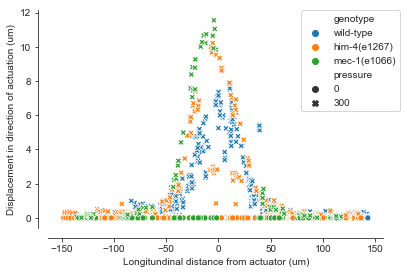

In [13]:
sns.set_style("ticks")

ax = sns.scatterplot(x='y', y='x_disp', data=linked_mitos_df, hue='genotype', style='pressure')
sns.despine(ax=ax, offset=10)
ax.set_xlabel('Longitundinal distance from actuator (um)')
ax.set_ylabel('Displacement in direction of actuation (um)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

# fig, ax = plt.subplots()
# ax = sns.scatterplot(x='y', y='z_disp', data=linked_mitos_df, hue='genotype', style='pressure')
# sns.despine(ax=ax, offset=10)
# ax.set_xlabel('Longitundinal distance from actuator (um)')
# ax.set_ylabel('Displacement in direction of actuation (um)')
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

## Create dataframe with data for pairs of adjacent mitochondria
- experiment id
- pair id
- particle ids
- frame number
- actuation pressure
- worm strain name
- genotype
- current distance between pairs
- stretch
- strain
### Match adjacent mitochondria into pairs

In [14]:
mito_pair_df_list = []
linked_mitos_df.sort_values(['Experiment_id', 'frame', 'y'], inplace=True)
for trial in linked_mitos_df['Experiment_id'].unique():
    for frame in linked_mitos_df.loc[linked_mitos_df['Experiment_id'] == trial]['frame'].unique():
        pair_count = 0
        # create iterrator to go through the particles of only this frame
        iterrator = linked_mitos_df.loc[
                (linked_mitos_df['Experiment_id'] == trial) &
                (linked_mitos_df['frame'] == frame)].iterrows() 
        # skip the first one, since we want to make pairs
        previous_index, previous_row = next(iterrator)
#         previous_row = first_row['particle']
        for index, row in iterrator:
            dist = distance.euclidean(previous_row[['x', 'y', 'z']], row[['x', 'y', 'z']])
            rest_dist = distance.euclidean(
                previous_row[['x_rest', 'y_rest', 'z_rest']], row[['x_rest', 'y_rest', 'z_rest']])
            this_mito_pair_dict = {
                'Experiment_id': row['Experiment_id'],
                'frame': row['frame'],
                'particle_1': previous_row['particle'],
                'particle_1_yval': previous_row['y'],
                'particle_2': row['particle'],
                'particle_2_yval': row['y'],
                'pair_id': pair_count,
                'pressure': row['pressure'],
                'worm_strain': row['worm_strain'],
                'genotype': row['genotype'],
                'distance': dist,
                'rest_dist': rest_dist}
            mito_pair_df_list.append(this_mito_pair_dict)
            pair_count += 1
            previous_row = row
mito_pair_df = pd.DataFrame(mito_pair_df_list)


In [15]:
# mito_pair_df.head()

### Calculate stretch and strain

In [16]:
def calc_stretch(row):
    return row['distance'] - row['rest_dist']

def calc_strain(row):
    return row['stretch'] / row['rest_dist']

mito_pair_df['stretch'] = mito_pair_df.apply(calc_stretch, axis=1)
mito_pair_df['strain'] = mito_pair_df.apply(calc_strain,axis=1)

### Plot strain at middle of actuator

88.14875912666321


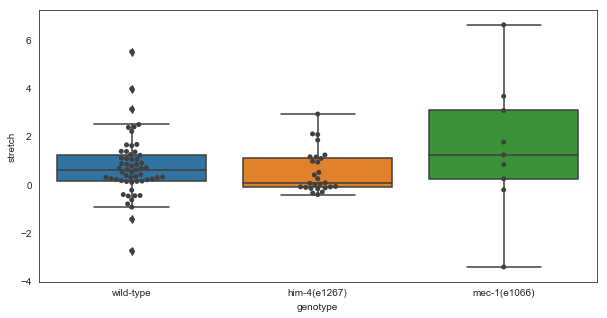

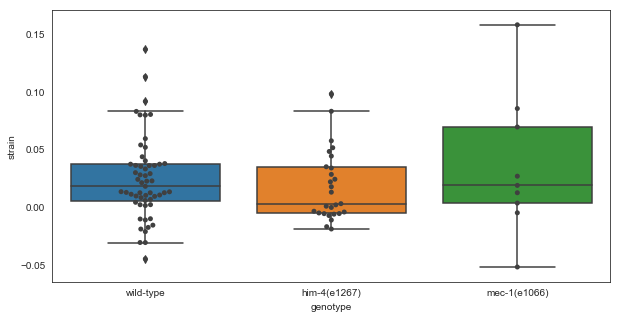

In [18]:
sns.set_style('white')
central_mito_pair_df = mito_pair_df.loc[
    ((mito_pair_df['particle_1_yval'] < 0) != 
     (mito_pair_df['particle_2_yval'] < 0)) &
    (mito_pair_df['pressure'] != 0)]
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='stretch', data=central_mito_pair_df, ax=ax)
sns.swarmplot(x='genotype', y='stretch', color=".25", data=central_mito_pair_df, ax=ax)

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='strain', data=central_mito_pair_df, ax=ax)
sns.swarmplot(x='genotype', y='strain', color=".25", data=central_mito_pair_df, ax=ax)

print(time.time()-start)

## Sanity checks to make sure calculations didn't go horribly wrong
#### rest distances actually match previous particle locations
#### displacements in multiple dimensions are vector sum of individual displacements
#### mitochondria pairs are correct
- correct number of pairs for each trial
- pairs are in correct order
- pair distance is correct using original particle locations
- pressure values are maintained properly